In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import LinearConstraint, Bounds
#%config InlineBackend.figure_format = 'retina'

def carregar_dados():
    precos = pd.read_csv("../dados/cotacoes-2021-jun-dez.csv", index_col=0, parse_dates=True)
#     cake = pd.read_csv("../dados/cake-2021-jan-ago.csv", index_col=0, parse_dates=True)
#     precos['CAKE'] = cake['price']

    return precos

def imprimir_resultado(simbolos, pesos):
    pesos = pesos * 100
    linha = ''
    for i in range(len(simbolos)):
        linha = linha + simbolos[i] + ": " + "%.2f" % pesos[i] + ', '
    print(linha)

#  retorna array com retorno, volatilidade e sharpe ratio da carteira
def calcular_desempenho(pesos):
    pesos = np.array(pesos)
    periodos = variacao_precos.count()[0]
    ret = np.sum(variacao_media * pesos) # retorno médio diário da carteira
    variacao_carteira = (variacao_precos * pesos).sum(axis=1) # variação diário do valor da carteira
    vol = variacao_carteira.std()
    sr = ret / vol

    return np.array([ret, vol, sr])

def neg_sharpe_ratio(pesos):
    return calcular_desempenho(pesos)[2] * -1     

def minimize_volatility(pesos):
    return calcular_desempenho(pesos)[1]

def calcular_variacao_precos_log(precos):
    variacao = np.log(precos/precos.shift(1))
    return variacao[1:]
    
def calcular_variacao_precos(precos):
    variacao = precos/precos.shift(1) - 1
    return variacao[1:]

In [2]:
precos = carregar_dados()
precos

,BTC-USD,ETH-USD,BNB-USD,ADA-USD,LINK-USD,SOL1-USD,DOT1-USD,UNI3-USD,LUNA1-USD,AVAX-USD,ALGO-USD,ATOM1-USD,EGLD-USD,LTC-USD
Date,,,,,,,,,,,,,,
2021-06-01,36684.925781,2633.518311,362.794647,1.734753,30.699013,30.985260,22.810846,27.395233,6.303989,17.773170,0.894697,13.757418,101.428307,182.980698
2021-06-02,37575.179688,2706.125000,401.262329,1.752824,30.656301,33.956318,25.957727,27.631479,6.841399,18.677080,1.018265,14.852793,103.495209,187.263977
2021-06-03,39208.765625,2855.126465,427.807922,1.840471,32.190559,39.470905,27.013458,28.630810,7.672640,20.243713,1.109922,16.637295,107.303017,193.086182
2021-06-04,36894.406250,2688.195068,391.395325,1.710908,28.875753,37.415070,25.008299,26.442995,6.385731,18.247404,1.028761,15.084727,96.500107,178.872009
2021-06-05,35551.957031,2630.576904,390.431854,1.659009,27.126797,39.585400,23.816771,25.607552,6.055346,17.250303,0.976601,14.873798,96.853714,173.028717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10,47243.304688,3908.496094,552.966858,1.211689,18.583904,167.954834,26.453915,15.173703,60.930698,80.739677,1.460471,22.576283,257.412201,148.598297
2021-12-11,49362.507812,4084.452393,564.322510,1.354248,19.949310,171.949493,27.774729,15.885549,59.984360,86.392815,1.526278,24.412264,255.982422,158.041916
2021-12-12,50098.335938,4134.453125,570.823975,1.347282,20.456585,173.431671,29.608980,16.017937,61.919449,88.109116,1.542000,24.574207,263.071075,159.203964


# Markowitz Efficient Frontier

In [7]:
variacao_precos = calcular_variacao_precos(precos)
variacao_media = variacao_precos.mean() # variação média por ativo
# variacao_media_cov = variacao_precos.cov() # covariância entre as variações dos preços dos ativos

In [4]:
variacao_precos

,BTC-USD,ETH-USD,BNB-USD,ADA-USD,LINK-USD,SOL1-USD,DOT1-USD,UNI3-USD,LUNA1-USD,AVAX-USD,ALGO-USD,ATOM1-USD,EGLD-USD,LTC-USD
Date,,,,,,,,,,,,,,
2021-06-02,0.024268,0.027570,0.106032,0.010417,-0.001391,0.095886,0.137955,0.008624,0.085249,0.050858,0.138112,0.079621,0.020378,0.023408
2021-06-03,0.043475,0.055061,0.066155,0.050003,0.050047,0.162402,0.040671,0.036166,0.121502,0.083880,0.090013,0.120146,0.036792,0.031091
2021-06-04,-0.059027,-0.058467,-0.085114,-0.070397,-0.102974,-0.052085,-0.074228,-0.076415,-0.167727,-0.098614,-0.073123,-0.093319,-0.100677,-0.073616
2021-06-05,-0.036386,-0.021434,-0.002462,-0.030334,-0.060568,0.058007,-0.047645,-0.031594,-0.051738,-0.054643,-0.050702,-0.013983,0.003664,-0.032667
2021-06-06,0.008731,0.032128,0.008679,0.011597,0.015659,0.068787,0.016158,0.011908,0.032013,0.008684,0.049457,0.015133,0.007053,0.020868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10,-0.008995,-0.051294,-0.032681,-0.061026,-0.084808,-0.072985,-0.018478,-0.063738,-0.083426,-0.055254,-0.057619,0.003576,-0.034930,-0.021061
2021-12-11,0.044857,0.045019,0.020536,0.117653,0.073473,0.023784,0.049929,0.046913,-0.015531,0.070017,0.045059,0.081323,-0.005554,0.063551
2021-12-12,0.014907,0.012242,0.011521,-0.005144,0.025428,0.008620,0.066040,0.008334,0.032260,0.019866,0.010301,0.006634,0.027692,0.007353


In [5]:
simbolos = precos.columns.tolist()
bounds = [(0,1)] * len(simbolos)
initial_guess = [1 / len(simbolos)] * len(simbolos) # pesos iniciais

In [15]:
pesos_retorno_max = [0] * len(simbolos)
# pesos_retorno_max
variacao_media.max()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [8]:
frontier_y = np.linspace(1, 2.45, 100)
frontier_x = []
sharpe_ratio = []
pesos = []

for possivel_retorno in frontier_y:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda w: calcular_desempenho(w)[0] - possivel_retorno})
    resultado = optimize.minimize(minimize_volatility, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(resultado['fun'])
    sharpe_ratio.append( calcular_desempenho(resultado.x)[2] )
    pesos.append(resultado.x)

KeyboardInterrupt: 

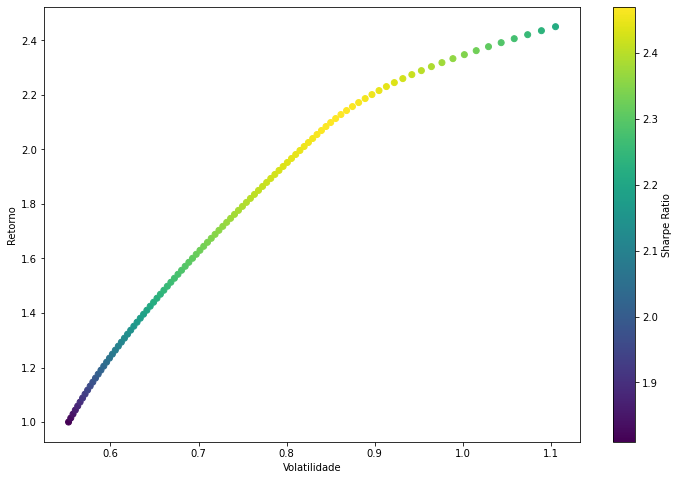

In [13]:
plt.figure(figsize=(12,8))
plt.scatter(frontier_x, frontier_y, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')

# plt.scatter(max_sratio_vol, max_sratio_ret, c='red')#, s=50) # red dot
plt.show()

In [14]:
carteiras = pd.DataFrame(columns=simbolos, data=pesos)
carteiras_formatadadas = carteiras.applymap(lambda x: "%.2f" % (x * 100) )

In [15]:
pd.set_option('display.max_rows', None)
print(carteiras_formatadadas)

      BTC   ETH   BNB   ADA  LINK    SOL   DOT   UNI   LUNA   AVAX  ALGO  \
0   58.54  0.00  0.00  0.00  0.00  16.89  0.00  0.00  16.60   0.08  0.00   
1   57.73  0.00  0.00  0.00  0.00  17.26  0.00  0.00  16.91   0.24  0.00   
2   56.92  0.00  0.00  0.00  0.00  17.63  0.00  0.00  17.22   0.39  0.00   
3   56.11  0.00  0.00  0.00  0.00  18.01  0.00  0.00  17.54   0.55  0.00   
4   55.31  0.00  0.00  0.00  0.00  18.38  0.00  0.00  17.85   0.70  0.00   
5   54.50  0.00  0.00  0.00  0.00  18.76  0.00  0.00  18.16   0.85  0.00   
6   53.70  0.00  0.00  0.00  0.00  19.14  0.00  0.00  18.48   1.00  0.00   
7   52.90  0.00  0.00  0.00  0.00  19.49  0.00  0.00  18.77   1.24  0.00   
8   52.10  0.00  0.00  0.00  0.00  19.86  0.00  0.00  19.09   1.40  0.00   
9   51.31  0.00  0.00  0.00  0.00  20.22  0.00  0.00  19.40   1.57  0.00   
10  50.51  0.00  0.00  0.00  0.00  20.58  0.00  0.00  19.72   1.73  0.00   
11  49.71  0.00  0.00  0.00  0.00  20.95  0.00  0.00  20.04   1.90  0.00   
12  48.91  0

In [16]:
soma = pd.DataFrame(carteiras.sum())
soma.applymap(lambda x: "%.2f" % (x * 100) )

,0
BTC,2175.41
ETH,0.00
BNB,0.00
ADA,0.00
LINK,0.00
SOL,3087.81
DOT,0.00
UNI,0.00
LUNA,3724.03
AVAX,554.92


### Carteira com maior sharpe ratio

In [17]:
max_sharpe_ratio = max(sharpe_ratio)
max_sharpe_index = sharpe_ratio.index(max_sharpe_ratio)
imprimir_resultado(simbolos, pesos[max_sharpe_index])

BTC: 0.00, ETH: 0.00, BNB: 0.00, ADA: 0.00, LINK: 0.00, SOL: 43.47, DOT: 0.00, UNI: 0.00, LUNA: 46.75, AVAX: 9.78, ALGO: 0.00, ATOM: 0.00, EGLD: 0.00, LTC: 0.00, 
